# Day 20: Jurassic Jigsaw

The high-speed train leaves the forest and quickly carries you south. You can even see a desert in the distance! Since you have some spare time, you might as well see if there was anything interesting in the image the Mythical Information Bureau satellite captured.

After decoding the satellite messages, you discover that the data actually contains many small images created by the satellite's camera array. The camera array consists of many cameras; rather than produce a single square image, they produce many smaller square image tiles that need to be reassembled back into a single image.

Each camera in the camera array returns a single monochrome image tile with a random unique ID number. The tiles (your puzzle input) arrived in a random order.

Worse yet, the camera array appears to be malfunctioning: each image tile has been rotated and flipped to a random orientation. Your first task is to reassemble the original image by orienting the tiles so they fit together.

To show how the tiles should be reassembled, each tile's image data includes a border that should line up exactly with its adjacent tiles. All tiles have this border, and the border lines up exactly when the tiles are both oriented correctly. Tiles at the edge of the image also have this border, but the outermost edges won't line up with any other tiles.

For example, suppose you have the following nine tiles:

```text
Tile 2311:
..##.#..#.
##..#.....
#...##..#.
####.#...#
##.##.###.
##...#.###
.#.#.#..##
..#....#..
###...#.#.
..###..###

Tile 1951:
#.##...##.
#.####...#
.....#..##
#...######
.##.#....#
.###.#####
###.##.##.
.###....#.
..#.#..#.#
#...##.#..

Tile 1171:
####...##.
#..##.#..#
##.#..#.#.
.###.####.
..###.####
.##....##.
.#...####.
#.##.####.
####..#...
.....##...

Tile 1427:
###.##.#..
.#..#.##..
.#.##.#..#
#.#.#.##.#
....#...##
...##..##.
...#.#####
.#.####.#.
..#..###.#
..##.#..#.

Tile 1489:
##.#.#....
..##...#..
.##..##...
..#...#...
#####...#.
#..#.#.#.#
...#.#.#..
##.#...##.
..##.##.##
###.##.#..

Tile 2473:
#....####.
#..#.##...
#.##..#...
######.#.#
.#...#.#.#
.#########
.###.#..#.
########.#
##...##.#.
..###.#.#.

Tile 2971:
..#.#....#
#...###...
#.#.###...
##.##..#..
.#####..##
.#..####.#
#..#.#..#.
..####.###
..#.#.###.
...#.#.#.#

Tile 2729:
...#.#.#.#
####.#....
..#.#.....
....#..#.#
.##..##.#.
.#.####...
####.#.#..
##.####...
##..#.##..
#.##...##.

Tile 3079:
#.#.#####.
.#..######
..#.......
######....
####.#..#.
.#...#.##.
#.#####.##
..#.###...
..#.......
..#.###...
```

By rotating, flipping, and rearranging them, you can find a square arrangement that causes all adjacent borders to line up:

```text
#...##.#.. ..###..### #.#.#####.
..#.#..#.# ###...#.#. .#..######
.###....#. ..#....#.. ..#.......
###.##.##. .#.#.#..## ######....
.###.##### ##...#.### ####.#..#.
.##.#....# ##.##.###. .#...#.##.
#...###### ####.#...# #.#####.##
.....#..## #...##..#. ..#.###...
#.####...# ##..#..... ..#.......
#.##...##. ..##.#..#. ..#.###...

#.##...##. ..##.#..#. ..#.###...
##..#.##.. ..#..###.# ##.##....#
##.####... .#.####.#. ..#.###..#
####.#.#.. ...#.##### ###.#..###
.#.####... ...##..##. .######.##
.##..##.#. ....#...## #.#.#.#...
....#..#.# #.#.#.##.# #.###.###.
..#.#..... .#.##.#..# #.###.##..
####.#.... .#..#.##.. .######...
...#.#.#.# ###.##.#.. .##...####

...#.#.#.# ###.##.#.. .##...####
..#.#.###. ..##.##.## #..#.##..#
..####.### ##.#...##. .#.#..#.##
#..#.#..#. ...#.#.#.. .####.###.
.#..####.# #..#.#.#.# ####.###..
.#####..## #####...#. .##....##.
##.##..#.. ..#...#... .####...#.
#.#.###... .##..##... .####.##.#
#...###... ..##...#.. ...#..####
..#.#....# ##.#.#.... ...##.....
```

For reference, the IDs of the above tiles are:

```text
1951    2311    3079
2729    1427    2473
2971    1489    1171
```

To check that you've assembled the image correctly, multiply the IDs of the four corner tiles together. If you do this with the assembled tiles from the example above, you get 1951 * 3079 * 2971 * 1171 = 20899048083289.

Assemble the tiles into an image. What do you get if you multiply together the IDs of the four corner tiles?

In [1]:
# Python imports
from math import prod
from pathlib import Path
from typing import List

import networkx as nx
import numpy as np

It looks like it will help to have a `Tile` object that knows what its edges are, and which compass direction they lie in.

We notice that the edges of the tiles are sequences of 0,1 so essentially define binary numbers. We should then be able to identify tiles to be joined by seeing that their edges have the same number (as an integer).

One subtlety is that we have to consider that the binary numbers can be read forwards or backwards, as the tiles may need to be flipped.

The tiles have attributes reflecting their unique tile ID, a `numpy` array containing the tile data, and a dictionary of edge numbers, keyed by direction.

In [2]:
class Tile:
    
    data: np.array
    tileid: int
    edgedirs: dict
        
    def __init__(self, tileid, data):
        self.tileid = tileid
        self.data = np.array(data)
        self.edgedirs = {}
        self.find_edges()

    def find_edges(self):
        self.edgedirs["north"] = int("".join((str(_) for _ in self.data[0,:])), 2)
        self.edgedirs["south"] = int("".join((str(_) for _ in self.data[-1,:])), 2)
        self.edgedirs["west"] = int("".join((str(_) for _ in self.data[:,0])), 2)
        self.edgedirs["east"] = int("".join((str(_) for _ in self.data[:,-1])), 2)
        
        self.edgedirs["north_rev"] = int("".join((str(_) for _ in self.data[0,:][::-1])), 2)
        self.edgedirs["south_rev"] = int("".join((str(_) for _ in self.data[-1,:][::-1])), 2)
        self.edgedirs["west_rev"] = int("".join((str(_) for _ in self.data[:,0][::-1])), 2)
        self.edgedirs["east_rev"] = int("".join((str(_) for _ in self.data[:,-1][::-1])), 2)

    @property
    def edges(self):
        return set(self.edgedirs.values())
    
    def __repr__(self):
        return f"<Tile {id(self)}: {self.tileid}, {self.edges}"

We load the data, reading each tile in as a `Tile` with its id.

In [3]:
def load_data(fpath):
    tiles = {}
    with Path(fpath).open("r") as ifh:
        for line in [_.strip() for _ in ifh.readlines()]:
            if line.startswith("Tile"):
                tileid = int(line.split()[-1][:-1])
                data = []
            elif len(line) == 0:
                tiles[tileid] = Tile(tileid, data)
            elif line[0] in "#.":
                data.append([1 if _ == "#" else 0 for _ in line])
            else:
                print("Error reading file")
        tiles[tileid] = Tile(tileid, data)
    return tiles

We notice that the tiles can be treated as nodes in a graph, where the edges of the graph are edges that a pair of tiles has in common. We create the `link_tiles()` function to produce such a graph from our loaded input.

In [4]:
def link_tiles(tiles):
    tiled = nx.Graph()
    for tile in tiles:
        tiled.add_node(tile.tileid)
    for idx1 in range(len(tiles) - 1):
        tile1 = tiles[idx1]
        for idx2 in range(idx1 + 1, len(tiles)):
            tile2 = tiles[idx2]
            if tile1.edges.intersection(tile2.edges):
                tiled.add_edge(tile1.tileid, tile2.tileid, edge_id=list(tile1.edges.intersection(tile2.edges))[0])
    return tiled

For such a graph, we can identify corners by locating the tiles that have only two edges, with the `find_corners()` function.

In [5]:
def find_corners(tilegraph):
    return [k for k, v in tilegraph.degree() if v == 2]

Testing this on the example data:

In [6]:
tiles = load_data("day20_test.txt")
tilegraph = link_tiles(list(tiles.values()))
find_corners(tilegraph)

[1951, 1171, 2971, 3079]

We correctly find the corners, so try our solution on the first puzzle data:

In [7]:
tiles = load_data("day20_data.txt")
tilegraph = link_tiles(list(tiles.values()))
prod(find_corners(tilegraph))

54755174472007

To convince ourselves this is all sensible, we can visualise the graph of the tiles.

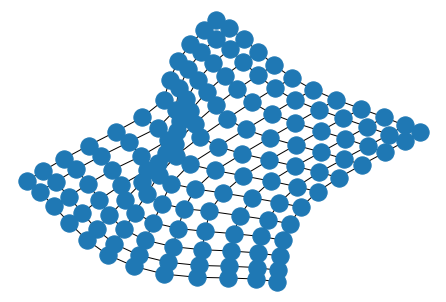

In [8]:
nx.draw(tilegraph)

## Part Two

Now, you're ready to check the image for sea monsters.

The borders of each tile are not part of the actual image; start by removing them.

In the example above, the tiles become:

```text
.#.#..#. ##...#.# #..#####
###....# .#....#. .#......
##.##.## #.#.#..# #####...
###.#### #...#.## ###.#..#
##.#.... #.##.### #...#.##
...##### ###.#... .#####.#
....#..# ...##..# .#.###..
.####... #..#.... .#......

#..#.##. .#..###. #.##....
#.####.. #.####.# .#.###..
###.#.#. ..#.#### ##.#..##
#.####.. ..##..## ######.#
##..##.# ...#...# .#.#.#..
...#..#. .#.#.##. .###.###
.#.#.... #.##.#.. .###.##.
###.#... #..#.##. ######..

.#.#.### .##.##.# ..#.##..
.####.## #.#...## #.#..#.#
..#.#..# ..#.#.#. ####.###
#..####. ..#.#.#. ###.###.
#####..# ####...# ##....##
#.##..#. .#...#.. ####...#
.#.###.. ##..##.. ####.##.
...###.. .##...#. ..#..###
```

Remove the gaps to form the actual image:

```text
.#.#..#.##...#.##..#####
###....#.#....#..#......
##.##.###.#.#..######...
###.#####...#.#####.#..#
##.#....#.##.####...#.##
...########.#....#####.#
....#..#...##..#.#.###..
.####...#..#.....#......
#..#.##..#..###.#.##....
#.####..#.####.#.#.###..
###.#.#...#.######.#..##
#.####....##..########.#
##..##.#...#...#.#.#.#..
...#..#..#.#.##..###.###
.#.#....#.##.#...###.##.
###.#...#..#.##.######..
.#.#.###.##.##.#..#.##..
.####.###.#...###.#..#.#
..#.#..#..#.#.#.####.###
#..####...#.#.#.###.###.
#####..#####...###....##
#.##..#..#...#..####...#
.#.###..##..##..####.##.
...###...##...#...#..###
```

Now, you're ready to search for sea monsters! Because your image is monochrome, a sea monster will look like this:

```text
                  # 
#    ##    ##    ###
 #  #  #  #  #  #   
```

When looking for this pattern in the image, the spaces can be anything; only the # need to match. Also, you might need to rotate or flip your image before it's oriented correctly to find sea monsters. In the above image, after flipping and rotating it to the appropriate orientation, there are two sea monsters (marked with O):

```text
.####...#####..#...###..
#####..#..#.#.####..#.#.
.#.#...#.###...#.##.O#..
#.O.##.OO#.#.OO.##.OOO##
..#O.#O#.O##O..O.#O##.##
...#.#..##.##...#..#..##
#.##.#..#.#..#..##.#.#..
.###.##.....#...###.#...
#.####.#.#....##.#..#.#.
##...#..#....#..#...####
..#.##...###..#.#####..#
....#.##.#.#####....#...
..##.##.###.....#.##..#.
#...#...###..####....##.
.#.##...#.##.#.#.###...#
#.###.#..####...##..#...
#.###...#.##...#.##O###.
.O##.#OO.###OO##..OOO##.
..O#.O..O..O.#O##O##.###
#.#..##.########..#..##.
#.#####..#.#...##..#....
#....##..#.#########..##
#...#.....#..##...###.##
#..###....##.#...##.##.#
```

Determine how rough the waters are in the sea monsters' habitat by counting the number of # that are not part of a sea monster. In the above example, the habitat's water roughness is 273.

How many # are not part of a sea monster?

The problem has become more difficult. We now need not only to identify linked tiles, but rotate and flip all the tiles into a common reference frame, so we can process the "image".

To do this, we introduce a `.reorient()` method to the `Tile` class. This takes two arguments: the edge of the a "static" tile it connects to, whose orientation is already correct and fixed; and the current direction of the connecing edge from this `Tile`. The method then rotates and/or flips the tile data as necessary to put the edge in the correct location to be oriented alongside the static tile, then updates the labelling of this tile's edges and unique edge identification numbers.

In [9]:
class Tile:
    
    data: np.array
    tileid: int
    edges: dict
    edgevals: dict
    visited: dict
    edgeset: set
        
    def __init__(self, tileid, data):
        self.tileid = tileid
        self.data = np.array(data)
        self.find_edges()
        self.visited = {"N": False, "S": False, "E": False, "W": False}
        self.nbrs = {"N": None, "S": None, "E": None, "W": None}

    def __allocate_edge(self, val, name):
        self.edges[name] = val
        self.edgevals[val] = name
        self.edgeset = set(self.edges.values())
        
    def find_edges(self):
        """Associate each edge with the edges dictionary and a value in edgevals"""
        self.edges = {}
        self.edgevals = {}
        # left->right numbers
        self.__allocate_edge(int("".join((str(_) for _ in self.data[0,:])), 2), "Nfwd")
        self.__allocate_edge(int("".join((str(_) for _ in self.data[-1,:])), 2), "Sfwd")
        # top->btm numbers
        self.__allocate_edge(int("".join((str(_) for _ in self.data[:, 0])), 2), "Wfwd")
        self.__allocate_edge(int("".join((str(_) for _ in self.data[:, -1])), 2), "Efwd")

        # right->left numbers
        self.__allocate_edge(int("".join((str(_) for _ in self.data[0,:][::-1])), 2), "Nrev")
        self.__allocate_edge(int("".join((str(_) for _ in self.data[-1,:][::-1])), 2), "Srev")
        # btm->top numbers
        self.__allocate_edge(int("".join((str(_) for _ in self.data[:, 0][::-1])), 2), "Wrev")
        self.__allocate_edge(int("".join((str(_) for _ in self.data[:, -1][::-1])), 2), "Erev")
        
    def reorient(self, staticdir, thisdir):
        """If necessary, rotate/flip tile data and reorient in order to match direction"""
        if (staticdir, thisdir) in [("Nfwd", "Sfwd"), ("Sfwd", "Nfwd"), ("Efwd", "Wfwd"), ("Wfwd", "Efwd")]:
            return
#             print("No rotation/flip required")
        elif (staticdir, thisdir) in [("Nfwd", "Srev"), ("Sfwd", "Nrev"), ("Efwd", "Efwd"), ("Wfwd", "Wfwd")]:
#             print("Flip this tile LR")
            self.data = np.fliplr(self.data)
            self.find_edges()
        elif (staticdir, thisdir) in [("Efwd", "Wrev"), ("Wfwd", "Erev"), ("Nfwd", "Nfwd"), ("Sfwd", "Sfwd")]:
#             print("Flip this tile UD")
            self.data = np.flipud(self.data)
            self.find_edges()
        elif (staticdir, thisdir) in [("Nfwd", "Erev"), ("Efwd", "Sfwd"), ("Sfwd", "Wrev"), ("Wfwd", "Nfwd")]:
#             print("90deg clockwise/270deg anticlockwise rotation of this tile")
            self.data = np.rot90(np.rot90(np.rot90(self.data)))
            self.find_edges()
        elif (staticdir, thisdir) in [("Nfwd", "Nrev"), ("Efwd", "Erev"), ("Sfwd", "Srev"), ("Wfwd", "Wrev")]:
#             print("180deg rotation of this tile")
            self.data = np.rot90(np.rot90(self.data))
            self.find_edges()
        elif (staticdir, thisdir) in [("Nfwd", "Wfwd"), ("Efwd", "Nrev"), ("Sfwd", "Efwd"), ("Wfwd", "Srev")]:
#             print("90deg anticlockwise/270deg clockwise rotation of this tile")
            self.data = np.rot90(self.data)
            self.find_edges()
        elif (staticdir, thisdir) in [("Nfwd", "Wrev"), ("Efwd", "Srev"), ("Sfwd", "Erev"), ("Wfwd", "Nrev")]:
#             print("90deg anticlockwise/270deg clockwise rotation of this tile then flip LR")
            self.data = np.fliplr(np.rot90(self.data))
            self.find_edges()
        elif (staticdir, thisdir) in [("Nfwd", "Efwd"), ("Sfwd", "Wfwd")]:
#             print("90deg clockwise/270deg anticlockwise rotation of this tile then LR flip")
            self.data = np.fliplr(np.rot90(np.rot90(np.rot90(self.data))))
            self.find_edges()
        elif (staticdir, thisdir) in [("Wfwd", "Sfwd"), ("Efwd", "Nfwd")]:
#             print("90deg anticlockwise/270deg clockwise rotation of this tile then UD flip")
            self.data = np.flipud(np.rot90(self.data))
            self.find_edges()
        else:
            print(f"Not done this one, yet: {staticdir} -> {thisdir}")
    
    def __repr__(self):
        return f"<Tile {id(self)}: {self.tileid}, {self.edges}"

As the way we represent `Tile` edges has changed, we need to update the `link_tiles()` function that identifies connected tiles:

In [10]:
def link_tiles(tiles):
    tiled = nx.Graph()
    for tile in tiles:
        tiled.add_node(tile.tileid)
    for idx1 in range(len(tiles) - 1):
        tile1 = tiles[idx1]
        for idx2 in range(idx1 + 1, len(tiles)):
            tile2 = tiles[idx2]
            if tile1.edgeset.intersection(tile2.edgeset):
                edge_id = list(tile1.edgeset.intersection(tile2.edgeset))[0]
                tile1.nbrs[tile1.edgevals[edge_id][0]] = tile2.tileid
                tile2.nbrs[tile2.edgevals[edge_id][0]] = tile1.tileid                
                tiled.add_edge(tile1.tileid, tile2.tileid, edge_id=edge_id)
    return tiled

We reorient tiles and stitch them together into a single image with the `stitch_tiles` function. This works as follows.

We start with the set of unoriented tiles. We choose a random tile from this set as the "seed" tile, and consider it to be correctly oriented.

Now, we work our way through the remaining unoriented tiles, trying to orient them against the "seed" tile. We check each edge of the oriented tile in turn against the members of the tile pool and, if it shares an edge, we reorient the new tile and add it to the *oriented* tile list, removing it from the main pool of tiles. Once we've tried all edges of the oriented tile, we take an unchecked tile from the *oriented* set, and make it the new "seed" tile. We repeat this until all tiles are oriented (the main tile pool is empty).

After this step, we link the oriented tiles into a graph, using the updated `link_tiles()` function. Then we find the corners and, specifically, the "NW" corner of the graph.

Using the NW corner as a marker, we identify the other members of the top row of the graph, and compile vertical columns from the data of all tiles below each of the members of the top row. Then we combine the columns into a single image. With each combination, we remove the outer edges of each image, as indicated in the puzzle description.

The `stitch_tiles()` function finally returns the compiled image as a `numpy` array.

In [11]:
def stitch_tiles(tiles):
    # orient the tiles so they can be stitched
    oriented_tiles = [tiles.pop()]
    
    # Select a tile at random from the oriented tiles
    while len(tiles):
        cur_tile = oriented_tiles.pop()
        
        # Check each unvisited edge for a potential match among the unoriented tiles
        for edgedir in [_ for _ in ("Nfwd", "Sfwd", "Efwd", "Wfwd") if not cur_tile.visited[_[0]]]:
            edgenum = cur_tile.edges[edgedir]
            # Does the edge occur in any of the unoeriented tiles?
            for tile in tiles:
                if edgenum in tile.edgevals:
#                     print(cur_tile.tileid, edgedir, tile.tileid, tile.edgevals[edgenum])
                    # Rotate/flip the new tile as needed
                    tile.reorient(edgedir, tile.edgevals[edgenum])
#                     print(tile.edgevals[edgenum])
                    oriented_tiles.append(tile)
                    tiles.remove(tile)
            cur_tile.visited[edgedir[0]] = True
        oriented_tiles = [cur_tile] + oriented_tiles

            
    # link the tiles and find the NW corner
    tiledict = {tile.tileid: tile for tile in oriented_tiles}
    tilegraph = link_tiles(oriented_tiles)
    nx.draw(tilegraph, with_labels=True)
    corners = find_corners(tilegraph)
#     print(corners)

    nw_corner = [_ for _ in corners if (tiledict[_].nbrs["W"] == tiledict[_].nbrs["N"] == None)][0]
    
    # Make columns of new array, starting from northwest corner
    cols = []
    cur_tile = tiledict[nw_corner]
    
    # Get top row IDs
    top_row = [nw_corner,]
    while cur_tile.nbrs["E"] is not None:
        cur_tile = tiledict[cur_tile.nbrs["E"]]
        top_row.append(cur_tile.tileid)
#     print(top_row)
        
    for cur_id in top_row:
        cur_tile = tiledict[cur_id]
        cur_array = cur_tile.data.copy()[1:]
        while cur_tile.nbrs["S"] is not None:
            cur_tile = tiledict[cur_tile.nbrs["S"]]
            # concatenate, but trim borders
            cur_array = np.concatenate((cur_array[:-1,:], cur_tile.data[1:]))
        cols.append(cur_array[:-1,1:-1])
        
    return np.concatenate(cols, axis=1)

We compile the *monster* from the puzzle as a `numpy` array, so we can search for it in the image.

In [12]:
monster = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
[1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,1],
[0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0]])
monster

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]])

To find the `monster` array in an image, we check all valid subarrays of the image that are the same size as the `monster` array, in turn. The check is to multiply (elementwise) the `monster` array with the subarray, and if the result is identical to `monster`, we have found it.

This test is implemented in `find_monsters()`:

In [13]:
def find_monsters(image, monster):
    monsters = []
    for i in range(image.shape[0] - monster.shape[0] + 1):
        for j in range(image.shape[1] - monster.shape[1] + 1):
#             if np.all(a[i:i+b.shape[0], j:j+b.shape[1]] == b):
            if np.all(np.multiply(image[i:i+monster.shape[0], j:j+monster.shape[1]], monster) == monster):
                monsters.append([i,j])
    return monsters

We could test all rotations and flips of the test image to locate the monsters (which occur only in a single transformation of the input matrix!), but in the cell below we go straight to the answer (a left-right flip, followed by a 90deg anticlockwise rotation).

The number of monster pixels is the number of occurrences of the monster (from `find_monsters()`) multiplied by the number of `1` pixels in `monster`. Then the "roughness" is the number of `1` pixels in the image minus the number of monster pixels.

We find the "roughness" for the test data:

273

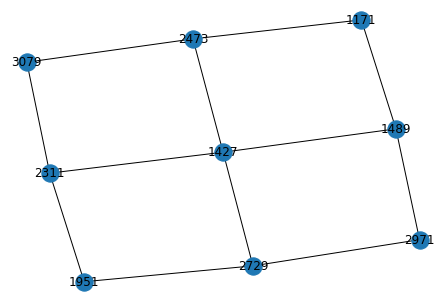

In [14]:
tiles = load_data("day20_test.txt")
stitched = stitch_tiles(list(tiles.values()))

stitched = np.rot90(np.fliplr(stitched))
sum(sum(stitched)) - (len(find_monsters(stitched, monster)) * sum(sum(monster)))

And then for the real puzzle data:

15

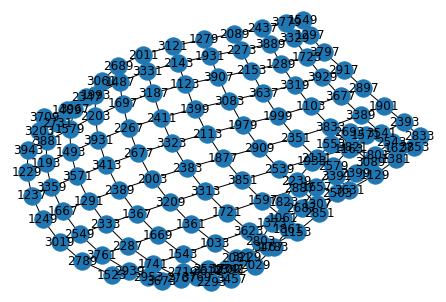

In [15]:
tiles = load_data("day20_data.txt")
stitched = stitch_tiles(list(tiles.values()))
len(find_monsters(np.rot90(np.rot90(stitched)), monster))

In [16]:
# Assume monsters do not overlap
sum(sum(monster)) * 15

225

In [17]:
# Total number of # is then all # seen minus the sum above
sum(sum(stitched)) - 225

1692